In [1]:
# Image compression for multi images by HOSVD 
# 2020, October, Tsuyothi Okubo

By using the low rank approximation through HOSVD, perform data compression of multiple color images. 

Here we use coil-100 data set obtained from
http://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php

It contains 7200 color images for 100 objects. Each object has 72 images taken from different oriantations. 
(Objects were set on a table which rotates through 360 degrees, and images were taken from intervals of 5 degrees.)
In total, the data set can be consider as a $100 \times 72 \times 128 \times 128 \times 3 $ tensor.


You can set the rank of the approximation by varying "chi_o", "chi_r", "chi_p", and "chi_c", that correspond to the ranks for objects, rotations, image pixels, and colors, respectively.

Let's see, how the images change when you change the ranks.

## Notice
By running this code, you will download the coil-100 dataset from the website. It needs about 150MB storage.
(Once you get the data, the code will not download it again.)
Instead, you can put the data, whidh was downloaded by yourself, to the current directory with the name "coil-100". In this case, the code will not download the data. 



In [2]:
## import libraries
from PIL import Image ## Python Imaging Library
import numpy as np ## numpy
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import requests
import zipfile
import os
dirname = "./coil-100/"
filename="coil-100.zip"
if os.path.exists(dirname):
    print("Use existing coil-100 directory")
elif os.path.exists(filename):
    print("Use exsingting coil-100.zip")
    with zipfile.ZipFile(filename) as existing_zip:
        existing_zip.extractall()
else:
    url="http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip"
    r = requests.get(url,stream=True)
    with open(filename, 'wb') as saveFile:
        saveFile.write(r.content)
    with zipfile.ZipFile(filename) as existing_zip:
        existing_zip.extractall()        

In [4]:
## Papameters for the low rank approximation by HOSVD 
n_image = 20 ## number of images (max = 100)

chi_o = 20 ## rank for object (max = n_image)
chi_r = 72 ## rank for rotation (max = 72)
chi_p = 30 ## rank for pixel (max = 128)
chi_c = 3 ## rank for color (max = 3)


In [5]:
array=[]
rotation = np.arange(0,360,5)
for n in range(1,n_image+1):
    for ir in range(72):
        filename = dirname+"obj"+repr(n)+"__"+repr(rotation[ir])+".png"
        #print(filename)
        img = Image.open(filename) ## load bmp image    
        array.append(np.array(img,dtype=float)) ## put into ndarray
array=np.array(array).reshape(n_image,72,array[0].shape[0],array[0].shape[1],array[0].shape[2])
print("Array shape:" +repr(array.shape)) ## print array shape


Array shape:(20, 72, 128, 128, 3)


In [6]:
array_truncated = np.zeros(array.shape)

print("HOSVD: chi_o=" +repr(chi_o) + ", chi_r=" + repr(chi_r) + ", chi_p=" + repr(chi_p) + ", chi_c=" + repr(chi_c))

HOSVD: chi_o=20, chi_r=72, chi_p=30, chi_c=3


In [7]:
## object
matrix = np.reshape(array,(array.shape[0],-1))
u,s,vt = np.linalg.svd(matrix[:,:],full_matrices=False) ## svd 
    
#truncation
uo = u[:,:min(chi_o,len(s))]

## rotation
matrix = np.reshape(np.transpose(array,(1,0,2,3,4)),(array.shape[1],-1))
u,s,vt = np.linalg.svd(matrix[:,:],full_matrices=False) ## svd 
    
#truncation
ur = u[:,:min(chi_r,len(s))]

## pixel row
matrix = np.reshape(np.transpose(array,(2,0,1,3,4)),(array.shape[2],-1))
u,s,vt = np.linalg.svd(matrix[:,:],full_matrices=False) ## svd 
    
#truncation
up_r = u[:,:min(chi_p,len(s))]

## pixel column
matrix = np.reshape(np.transpose(array,(3,0,1,2,4)),(array.shape[3],-1))
u,s,vt = np.linalg.svd(matrix[:,:],full_matrices=False) ## svd 
    
#truncation
up_c = u[:,:min(chi_p,len(s))]

## pixel color
matrix = np.reshape(np.transpose(array,(4,0,1,2,3)),(array.shape[4],-1))
u,s,vt = np.linalg.svd(matrix[:,:],full_matrices=False) ## svd 
    
#truncation
uc = u[:,:min(chi_c,len(s))]


In [8]:
## make projectors
po = np.dot(uo,(uo.conj()).T)
pr = np.dot(ur,(ur.conj()).T)
pp_r = np.dot(up_r,(up_r.conj()).T)
pp_c = np.dot(up_c,(up_c.conj()).T)
pc = np.dot(uc,(uc.conj()).T)


In [9]:
## make truncated array
array_truncated = np.tensordot(np.tensordot(np.tensordot(np.tensordot(np.tensordot(array,po,axes=(0,1)),pr,axes=(0,1)),pp_r,axes=(0,1)),pp_c,axes=(0,1)),pc,axes=(0,1))
normalized_distance = np.sqrt(np.sum((array-array_truncated)**2))/np.sqrt(np.sum(array**2))
print("Low rank approximation by HOSVD with chi_o=" +repr(chi_o) + ", chi_r=" + repr(chi_r) + ", chi_p=" + repr(chi_p) + ", chi_c=" + repr(chi_c))
print("Normalized distance:" +repr(normalized_distance)) ## print normalized distance

Low rank approximation by HOSVD with chi_o=20, chi_r=72, chi_p=30, chi_c=3
Normalized distance:0.0887587430657504


## Approximated images
In the following we show several images before and after the low rank approximation.

By changing 
* images
* image_rot

you can select images to be shown.

In [10]:
images = [0,1,2,3,4] ## indices of images to be shown.
image_rot = 2  ## index of the image to be shown with rotation.

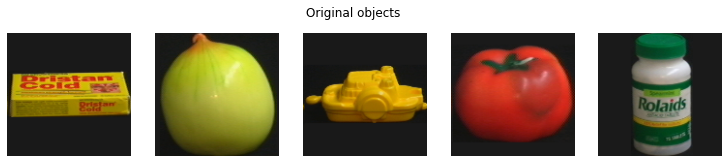

In [11]:
plt.figure(figsize=(2.56*len(images),2.56))
plt.suptitle("Original objects")
for i in range(len(images)):
    img = Image.fromarray(np.uint8(np.clip(array[images[i],0,:,:,:],0,255))) ## convert to each image
    plt.subplot(1,len(images), i+1)
    plt.axis("off")
    plt.imshow(img)


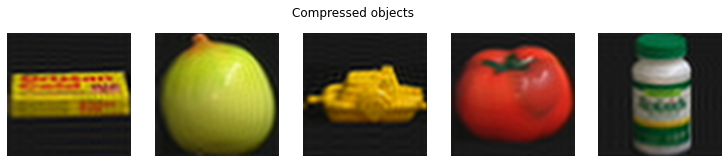

In [12]:
plt.figure(figsize=(2.56*len(images),2.56))
plt.suptitle("Compressed objects")
for i in range(len(images)):
    img_truncated = Image.fromarray(np.uint8(np.clip(array_truncated[images[i],0,:,:,:],0,255))) ## convert to each image
    plt.subplot(1,len(images), i+1)
    plt.axis("off")   
    plt.imshow(img_truncated)


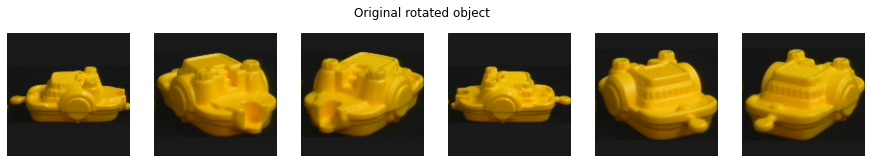

In [13]:
plt.figure(figsize=(2.56*6,2.56))
plt.suptitle("Original rotated object")
for i in range(6):
    img = Image.fromarray(np.uint8(np.clip(array[image_rot,i*12,:,:,:],0,255))) ## convert to each image
    plt.subplot(1,6, i+1)
    plt.axis("off")
    plt.imshow(img)


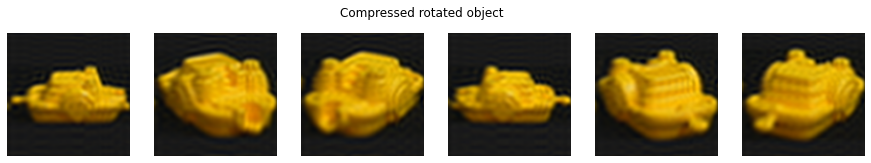

In [17]:
plt.figure(figsize=(2.56*6,2.56))
plt.suptitle("Compressed rotated object")
for i in range(6):
    img_truncated = Image.fromarray(np.uint8(np.clip(array_truncated[image_rot,i*12,:,:,:],0,255))) ## convert to each image
    plt.subplot(1,6, i+1)
    plt.axis("off")
    plt.imshow(img_truncated)


In [15]:
plt.show()